# DRC Roads - UDM2

This notebook implements forest/non-forest classification on PSOrthotiles which utilizes the
Usable Data Mask (UDM2) for image and pixel filtering. The original forest change classification
workflow utilized Unusable Data Mask (UDM) to determine scene quality and filter out bad pixels.
Since that workflow was implemented, the Usable Data Mask (UDM2) was released. This asset provides
additional information on pixel usability. In this notebook, we assess the impact of UDM2 on
forest/non-forest classification to determine whether it is an improvement over UDM.

The UDM2 asset was released in August of 2019. Therefore, while the original forest monitoring
workflow used imagery from September to December 2017, this notebook uses imagery from August 1, 2018 to May 30, 2019
(the original release date of this notebook). Unfortunately, this change in search date resulted in
less useful imagery being found, with just two set being found.

Ultimately, we find that UDM2 for the two image sets that were found does not identify haze in the imagery, so classification results are still affected by haze in the imagery. 

*NOTE* This notebook uses a lot of code that was developed in the original forest monitoring workflow.

In [38]:
from collections import OrderedDict
import datetime
from functools import reduce
import json
import os
import subprocess
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from planet import api
from planet.api import downloader, filters
import rasterio
from skimage import feature as skfeature, filters as skfilters
from sklearn.ensemble import RandomForestClassifier
from shapely import geometry as sgeom
from shapely.ops import cascaded_union

## Define AOI

The AOI is a region in the Democratic Republic of Congo that experiences road development between September and November 2017. It is a rectangle that overlaps orthotile grid cell boundaries. Usually, we would redefine the AOI to be within an Orthotile, but we would lose a lot of context if we limited this AOI to only one Orthotile grid cell.

In [2]:
aoi = {"geometry": {
    "type":"Polygon",
    "coordinates":
        [[
            [25.42429478260258,1.0255377823058893],
            [25.592960813580472,1.0255377823058893],
            [25.592960813580472,1.1196578801254304],
            [25.42429478260258,1.1196578801254304],
            [25.42429478260258,1.0255377823058893]
        ]]}}

item_type = 'PSOrthoTile'

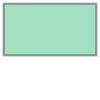

In [3]:
aoi_shape = sgeom.shape(aoi['geometry'])
aoi_shape

In [4]:
def create_save_dir(root_dir='data'):
    save_dir = root_dir

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    return save_dir

def save_geojson_file(aoi_geojson, save_dir):
    filename = os.path.join(save_dir, 'aoi.geojson')
    with open(filename, "w") as f:
        f.write(json.dumps(aoi_geojson))
    return filename

geojson_filename = save_geojson_file(aoi, create_save_dir('pre-data'))
print('wrote AOI to {}'.format(geojson_filename))

wrote AOI to pre-data/aoi.geojson


## Download and Mosaic Multiple Strip Orthotile COGs

To download and mosaic multiple strip Orthotile COGs, we use the bulkdownloader from the planet python client. In this downloader, called `StripDownloader`, we activate the scenes and use `gdal` to download and mosaic the COGs.

In [5]:
# we use gdalwarp to only download the aoi portion of the COGs
# and mosaic them in one step
def _gdalwarp(input_filenames, output_filename, options, verbose=False):
    commands = ['gdalwarp'] + options + \
               ['-overwrite'] + \
               input_filenames + \
               [output_filename]
    if verbose: print(' '.join(commands))
    subprocess.check_call(commands)

# lossless compression of an image
def _compress(input_filename, output_filename, verbose=False):
    commands = ['gdal_translate',
                '-co', 'compress=LZW',
                '-co', 'predictor=2',
                input_filename,
                output_filename]
    if verbose: print(' '.join(commands))
    subprocess.check_call(commands)

def download_strip_aoi(download_urls, output_filename, geojson_filename,
                       compress=False, verbose=False):
    vsicurl_urls = ['/vsicurl/' + d for d in download_urls]
    options = [
        '-cutline', geojson_filename,
        '-crop_to_cutline',
    ]
    
    if compress:
        with tempfile.NamedTemporaryFile(suffix='.vrt') as vrt_file:
            options += ['-of', 'vrt']
            _gdalwarp(vsicurl_urls, vrt_file.name, options, verbose=verbose)
            _compress(vrt_file.name, output_filename, verbose=verbose)
    else:
        _gdalwarp(vsicurl_urls, output_filename, options, verbose=verbose)

In [6]:
class StripDownloader(object):
    '''Activates, downloads, and mosaics COGs'''
    def __init__(self, scenes, geojson_file, client, root_dir='data'):
        self.scenes = scenes #pandas DataFrame describing scenes to download
        self.geojson_file = geojson_file
        self.client = client
        self.save_dir = root_dir
        
        self.item_type = 'PSOrthoTile'

        self.urls = dict() # this will be populated by on_complete()
        self.strip_mosaics = [] # this will be populated by on_complete()
        
        self.strip_scenes = self._scenes_to_strip_scenes()
    
    def _scenes_to_strip_scenes(self):
        strip_ids = self.scenes.strip_id.unique()
        print('{} strips'.format(len(strip_ids)))
        
        strip_scenes = dict()
        for sid in strip_ids:
            strip_scenes[sid] = self.scenes[self.scenes['strip_id'] == sid].id.tolist()
        return strip_scenes
        

    def get_on_complete(self, asset_type, verbose=False):
        def on_complete(item, asset):
            download_url = asset['location']
            scene_id = item['id']
            if verbose: print('{}'.format(scene_id))

            strip_id = item['properties']['strip_id']
            if self._completes_strip_scenes(strip_id, scene_id):
                # do this after check that this scene_id completes a strip to avoid
                # a race condition causing scene to be downloaded multiple times
                self.urls[scene_id] = download_url
            
                output_file = self.get_filename(strip_id, asset_type)
                self._download_strip_mosaic(strip_id, output_file, verbose)
                self.strip_mosaics.append(output_file)
            else:
                self.urls[scene_id] = download_url

        return on_complete

    def _completes_strip_scenes(self, strip_id, scene_id):
        activated_scenes_set = set(list(self.urls.keys()) + [scene_id])
        strip_scenes_set = set(self.strip_scenes[strip_id])
        return strip_scenes_set.intersection(activated_scenes_set) == strip_scenes_set
    
    def get_filename(self, strip_id, asset_type):
        if not os.path.isdir(self.save_dir): os.makedirs(self.save_dir)
        
        filename = strip_id + '_' + asset_type + '_mosaic.tif'
        filepath = os.path.join(self.save_dir, filename)
        return filepath
  
    def _download_strip_mosaic(self, strip_id, output_file, verbose):
        scene_ids = self.strip_scenes[strip_id]
        download_urls = [self.urls[scene_id]
                         for scene_id in scene_ids]

        if verbose: print('downloading {} as {}'.format(scene_ids, output_file))
        download_strip_aoi(download_urls, output_file, self.geojson_file, verbose=verbose)
    
    def run(self, asset_type, overwrite=False, verbose=False):
        # filter scenes by those that already exist
        if not overwrite:
            dl_strip_scenes = self._filter_by_existing_strip_mosaics(self.strip_scenes,
                                                                     asset_type,
                                                                     verbose)
        else:
            dl_strip_scenes = self.strip_scenes

        if len(dl_strip_scenes):
            dl = downloader.create(self.client)
            dl.on_complete = self.get_on_complete(asset_type, verbose=verbose)
            dl.shutdown()
            dl.activate(iter(self._get_items()), [asset_type])
        elif verbose:
            print('Nothing to download')
    
    def _filter_by_existing_strip_mosaics(self, strip_scenes, asset_type, verbose):
        def _strip_mosaic_exists(strip_id):
            strip_mosaic_filename = self.get_filename(strip_id, asset_type)
            
            found = False
            if os.path.isfile(strip_mosaic_filename):
                found = True
                if verbose: print('found {}'.format(strip_mosaic_filename))
            return found
        
        filtered_strip_ids = (s for s in strip_scenes.keys()
                              if not _strip_mosaic_exists(s))
        
        filt_strip_scenes = {sid: strip_scenes[sid] for sid in filtered_strip_ids}
        return filt_strip_scenes
        
    def _get_items(self):
        return [self.client.get_item(self.item_type, sid).get()
                for sid in self.scenes.id.tolist()]

## Search for Scenes Based on Mosaic Scene Usefulness

In this section, we create a scene search that filters scenes based on the percentage of useful pixels in the resulting mosaic scene, as determined from the Usable Data Map (UDM2), an asset available alongside the images. This search is implemented in `StripSearcher`.

In [8]:
# Utility functions for loading a UDM2 image, loading
# individual UDM2 bands as a mask, and identifying bands as
# class labels
def load_udm2(udm2_filename):
    '''Load multi-band UDM2 as a 3d array.'''
    with rasterio.open(udm2_filename, 'r') as src:
        udm2 = src.read()
    return udm2

def load_udm2_mask(udm2_filename, band_num):
    with rasterio.open(udm2_filename) as src:
        mask = src.read(band_num).astype(bool)
    return mask

udm2_labels = ['clear', 'snow', 'shadow', 'light haze', 'heavy haze', 'cloud',
               'confidence', 'unusable pixels']

In [9]:
# Utility functions for searching using the Planet data api
def search_pl_api(client, request, limit=500):
    result = client.quick_search(request)
    
    # note that this returns a generator
    return result.items_iter(limit=limit)

def build_ps_request(aoi, item_type, begin, end):
    search_aoi = aoi['geometry']
    query = filters.and_filter(
        filters.geom_filter(search_aoi),
        filters.range_filter('clear_percent', gte=90),
        filters.date_range('acquired', gte=begin),
        filters.date_range('acquired', lt=end)
    )

    # build a request for only PlanetScope imagery
    request = filters.build_search_request(
        query, item_types=[item_type]
    )
    
    return request

def items_to_scenes(items):
    '''convert data api item type to a pandas Dataframe with scene metadata'''
    item_types = []

    def _get_props(item):
        props = item['properties']
        
        # add data not in properties list
        props.update({
            'thumbnail': item['_links']['thumbnail'],
            'id': item['id'],
            'footprint': item['geometry'],
        })
        return props
    
    scenes = pd.DataFrame(data=[_get_props(i) for i in items])
    
    # convert acquired from string to datetime for processing
    scenes['acquired'] = pd.to_datetime(scenes['acquired'])
    
    return scenes

In [10]:
# Utility functions for filtering based on scene overlap with aoi
def aoi_intersection(footprint, aoi):
    '''calculates the shape and percent of the intersection between
    the footprint and the aoi as a pandas Series'''
    aoi_shape = sgeom.shape(aoi['geometry'])
    footprint_shape = sgeom.shape(footprint)
    intersection_shape = aoi_shape.intersection(footprint_shape)

    try:
        intersection_percent = 100 * footprint_shape.area / intersection_shape.area
    except ZeroDivisionError:
        intersection_percent = 0

    data = {'intersection_shape': intersection_shape,
            'intersection_fp_perc': intersection_percent}
    return pd.Series(data=data)

def get_strip_aoi_inter(group, aoi):
    '''
    calculate strip intersection with aoi
    
    group: data frame with strip id as index
    '''
    intersections = group['intersection_shape'].tolist()
    intersection_shape = cascaded_union(intersections)
    aoi_shape = sgeom.shape(aoi['geometry'])

    try:
        intersection_percent = 100 * intersection_shape.area / aoi_shape.area
    except ZeroDivisionError:
        intersection_percent = 0 

    data = {'strip_intersection_shape': intersection_shape,
            'strip_intersection_aoi_perc': intersection_percent}
    return pd.Series(data=data)

In [11]:
class StripSearcher(object):
    '''Searches for strips that overlap the aoi by a certain percent and 
    are determined to be clear by a certain percent.'''
    def __init__(self, aoi_geojson, begin, end, client, root_dir='data',
                 overlap_percent=70, clear_percent=70,
                 verbose=False):
        self.aoi = aoi_geojson # aoi geojson
        self.begin = begin # datetime indicating begin date
        self.end = end # datetime indicating end date
        
        self.client = client
        self.save_dir = root_dir
        
        self.item_type = 'PSOrthoTile'
        self.udm2_asset_type = 'udm2'
        
        self.overlap_percent = overlap_percent
        self.clear_percent = clear_percent
        
        self.verbose = verbose
        
        self.overlapping_scenes = None # this is populated by get_overlapping_scenes()
        self.good_scenes = None # this is populated by get_good_scenes()
    
    def search(self, geojson_filename=None, use_udm=True):
        self.get_overlapping_scenes()
        if use_udm:
            if geojson_filename is None:
                raise('Must specify geojson_filename')

            good_strip_ids = self.get_good_strip_ids(geojson_filename)
            all_strip_ids = self.get_strip_ids(self.overlapping_scenes)
            print('Filtered to {} strips out of {} strips.'.format(
                len(good_strip_ids), len(all_strip_ids)))
            scenes = self.get_scenes_by_ids(good_strip_ids)
        else:
            scenes = self.overlapping_scenes
        print('{} OrthoTiles found'.format(len(scenes)))
        return scenes
        
    def get_overlapping_scenes(self):
        # get all scenes that fit search
        items = search_pl_api(self.client,
                              build_ps_request(self.aoi, self.item_type, self.begin, self.end))
        scenes = items_to_scenes(items)
        print('{} OrthoTiles were returned from the api search.'.format(len(scenes)))
        
        # filter to scenes where footprint overlaps aoi
        intersections = scenes.footprint.apply(aoi_intersection, args=(self.aoi,))
        scenes_inter = pd.concat([scenes, intersections], axis=1, sort=False)
        scenes_inter = scenes_inter[scenes_inter.intersection_fp_perc > 0]
        print('There are {} OrthoTiles that overlap aoi.'.format(len(scenes_inter)))
        
        # filter to scenes in strips that have significant overlap
        scenes_sid = scenes_inter.groupby(['strip_id'])
        strip_aoi_inter = scenes_sid.apply(get_strip_aoi_inter, aoi=self.aoi)
        strips_filt = strip_aoi_inter[strip_aoi_inter.strip_intersection_aoi_perc > self.overlap_percent]
        
        overlapping_strip_ids = strips_filt.index.tolist()
        overlapping_scenes = scenes[scenes['strip_id'].isin(overlapping_strip_ids)]  
        print('There are {} OrthoTiles in {} strips that significantly overlap the aoi.'.format(
            len(overlapping_scenes), len(overlapping_strip_ids)))
        
        self.overlapping_scenes = overlapping_scenes
    
    def get_overlapping_strips(self):
        return [s for s in self.overlapping_scenes.strip_id.unique().tolist()]

    def get_strip_ids(self, scenes):
        return[s for s in scenes.strip_id.unique().tolist()]
        
    def get_good_strip_ids(self, geojson_filename):
        strip_downloader = StripDownloader(self.overlapping_scenes,
                                           geojson_filename,
                                           self.client)
        strip_downloader.run(self.udm2_asset_type, overwrite=False, verbose=self.verbose)
        
        strip_ids = self.get_overlapping_strips()
        udm2_strip_mosaics = [strip_downloader.get_filename(i, self.udm2_asset_type)
                              for i in strip_ids]
        
        strip_quality = [self._is_good_udm2(u) for u in udm2_strip_mosaics]
        
        good_strips = [sid for (sid, squality) in zip(strip_ids, strip_quality) if squality]
        return good_strips

    def _is_good_udm2(self, udm2_strip_mosaic):
        # clear band is band 1
        # True: clear
        clear = ~load_udm2_mask(udm2_strip_mosaic, 1)
        clear_percent = ((np.size(clear) - np.count_nonzero(clear)) / np.size(clear)) * 100
        return clear_percent > self.clear_percent
    
    def get_scenes_by_ids(self, strip_ids):
        scenes = self.overlapping_scenes.copy()
        return scenes[scenes['strip_id'].isin(strip_ids)]

In [12]:
planet_api_key = os.environ['PL_API_KEY']

# quick check that key is defined
assert planet_api_key, "PL_API_KEY not defined."

client = api.ClientV1(api_key=planet_api_key)

In [13]:
begin=datetime.datetime(year=2018,month=8,day=1)
end=datetime.datetime(year=2019,month=5,day=30)
strip_searcher = StripSearcher(aoi, begin, end, client, overlap_percent=50, clear_percent=70)
good_scenes = strip_searcher.search(geojson_filename)

21 OrthoTiles were returned from the api search.
There are 21 OrthoTiles that overlap aoi.
There are 8 OrthoTiles in 2 strips that significantly overlap the aoi.
2 strips
Filtered to 2 strips out of 2 strips.
8 OrthoTiles found


### Visualize scenes and UDM2

Two strips were found to match the quality criteria and have the UDM2 asset. Before classifying the strips, we visualize them alongside the UDM2.

In [14]:
# load local visual module
import visual

def load_4band(filename):
    with rasterio.open(filename, 'r') as src:
        # visual band ordering: red, green, blue, alpha
        b, g, r, n = src.read() 

        # NoData value is 0
        mask = b == 0

    return [np.ma.array(band, mask=mask) for band in [b, g, r, n]]

def visualize_4band(bgrn_bands, title='Orthotile Strip Mosaic', figdim=15):
    rgb_bands = [bgrn_bands[i] for i in [2, 1, 0]]
    visual.plot_image(rgb_bands, title=title, figsize=(figdim, figdim))
    
# Decimate image band arrays for memory conservation
def decimate(arry, num=16):
    return arry[::num, ::num].copy()

def visualize_image_with_udm2(strip_downloader, strip_id, asset_type):
    img_filename = strip_downloader.get_filename(strip_id, asset_type)
    img = load_4band(img_filename)
    visualize_4band([decimate(b) for b in img], title=strip_id, figdim=15)

    udm2_filename = strip_downloader.get_filename(strip_id, udm2_asset_type)
    clear = 1*decimate(load_udm2_mask(udm2_filename, 1))
    clear_labels = {0: 'not clear', 1: 'clear'}
    visual.plot_classified_band(clear, class_labels=clear_labels,
                                title=strip_id + ' UDM2 - clear',
                                figdim=15)

In [66]:
asset_type = 'analytic'
udm2_asset_type='udm2'

verbose = True
overwrite = False
strip_downloader = StripDownloader(good_scenes, geojson_filename, client)
strip_downloader.run(asset_type, overwrite=overwrite, verbose=verbose)

2 strips
found data/2334749_analytic_mosaic.tif
found data/2332245_analytic_mosaic.tif
Nothing to download


In [67]:
strip_downloader.run(udm2_asset_type, overwrite=overwrite, verbose=verbose)

found data/2334749_udm2_mosaic.tif
found data/2332245_udm2_mosaic.tif
Nothing to download


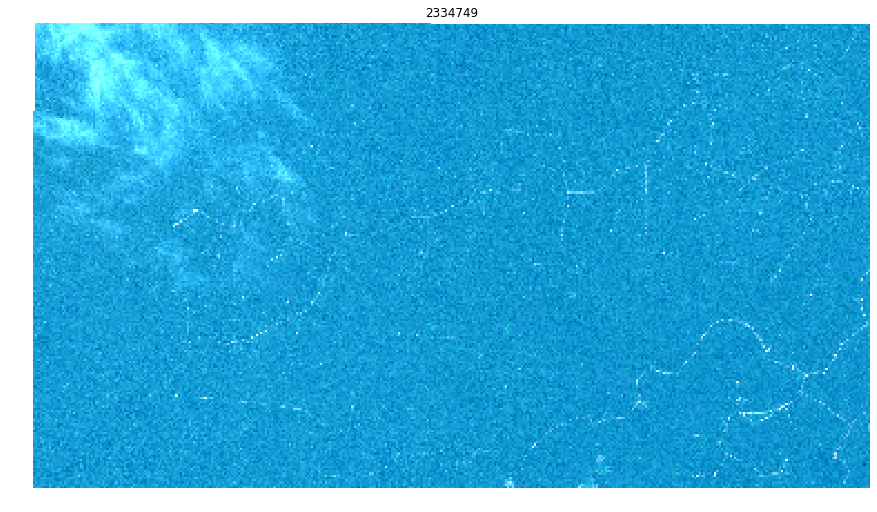

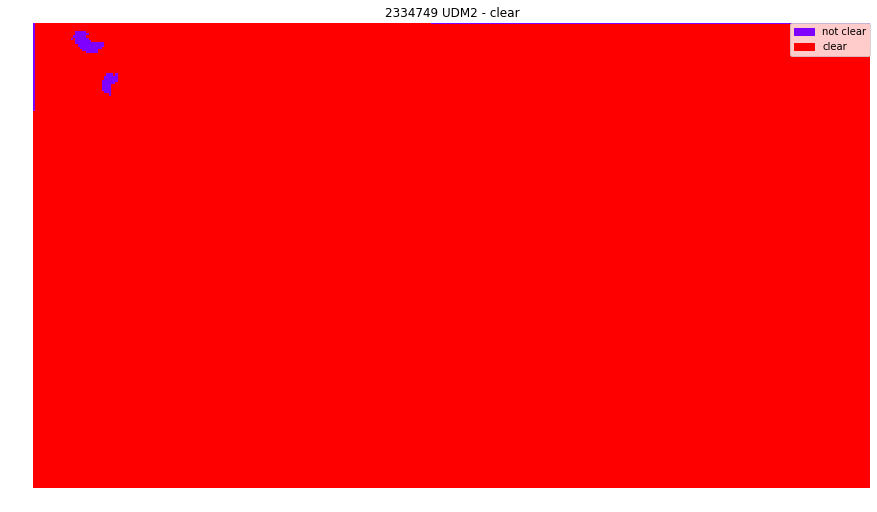

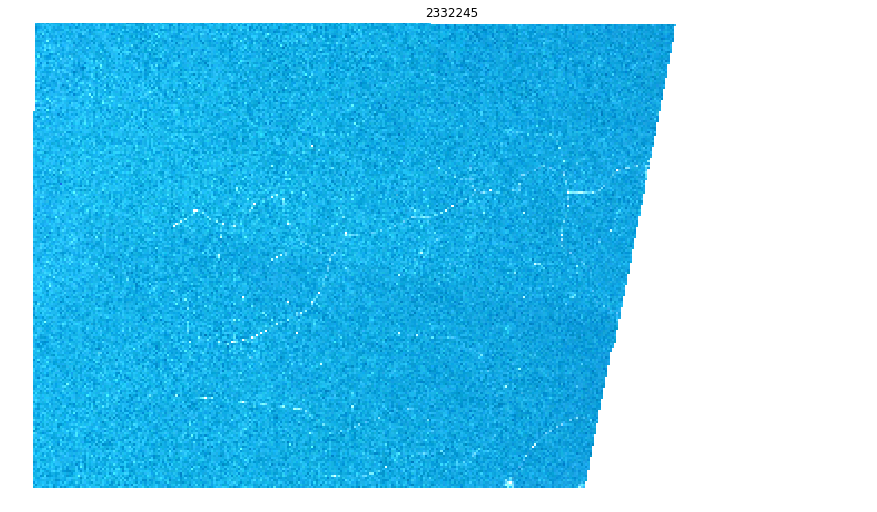

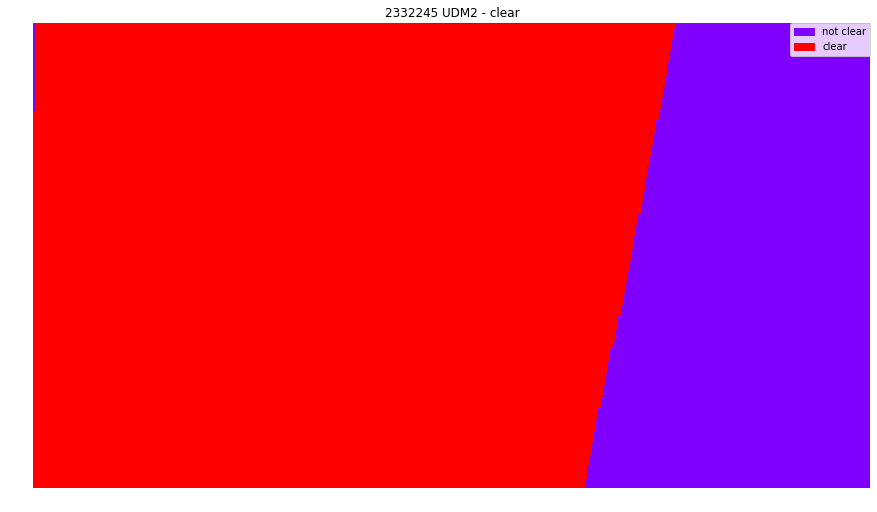

In [70]:
for strip_id in strip_searcher.get_strip_ids(good_scenes):
    visualize_image_with_udm2(strip_downloader, strip_id, asset_type)

## Classify Roads with Random Forests


To test classification, we use Random Forest Classification, which has proven to be an effective classification technique for identifying forest and non-forest regions.

Random Forest Classification is a supervised classification technique so we must load and prepare the label and feature data and train the classifier.

### Load Label Data

In [24]:
forest_img = os.path.join('pre-data', 'forestroad_forest.tif')
road_img = os.path.join('pre-data', 'forestroad_road.tif')

In [27]:
def get_label_mask(image_filename):
    with rasterio.open(image_filename, 'r') as src:
        band = src.read(1)
        label_data = band == 255 # valid data in white regions
        label_mask = ~label_data # mask True (masked) for not valid data
    return label_mask

def get_unmasked_count(mask):
    return np.size(mask) - np.count_nonzero(mask)

forest_mask = get_label_mask(forest_img)
print(get_unmasked_count(forest_mask))

road_mask = get_label_mask(road_img)
print(get_unmasked_count(road_mask))

forest_mask.shape

/opt/conda/lib/python3.6/site-packages/rasterio/__init__.py:217: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


6652509
17219


(3333, 6008)

### Prepare Training Image

The mosiac image and label image are just a few pixels different in size so resample the mosaic to match the label image.

In [51]:
# specify the training dataset mosaic image file
strip_id = strip_searcher.get_strip_ids(good_scenes)[1]
image_file = strip_downloader.get_filename(strip_id, asset_type)

In [52]:
# this is the georeferenced image that was used to create the forest and non-forest label images
label_image = 'pre-data/roads.tif'

In [53]:
# get label image crs, bounds, and pixel dimensions
with rasterio.open(label_image, 'r') as ref:
    width = ref.width
    height = ref.height

print((height, width))

(3333, 6008)


In [54]:
# this is the warped training mosaic image we will create with gdal
training_file = os.path.join('data', 'udm2_training.tif')

In [55]:
# use gdalwarp to warp mosaic image to match label image
!gdalwarp -ts $width $height \
    -overwrite $image_file $training_file

Creating output file that is 6008P x 3333L.
Processing data/2332245_analytic_mosaic.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


### Create Training Datasets

We process the training image to feature bands, which consist of the RGBNir bands as well as texture-encoded bands. From the features bands, we pull a sample set of pixels from each class, with random sampling of the pixels, to ensure that the sample sizes are the same for the classes.

In [56]:
def get_texture_features(bands):
    green_band = bands[1]
    edges1 = skfeature.canny(green_band, low_threshold=0.0, high_threshold=0.01, sigma=2)
    blurred = skfilters.gaussian(edges1, sigma=2)
    blurred2 = skfilters.gaussian(edges1, sigma=6)
    return [np.ma.array(texture_band, mask=green_band.mask)
            for texture_band in (blurred, blurred2)]

def get_feature_bands(image_file):
    spectral_bands = load_4band(image_file)
    texture_bands = get_texture_features(spectral_bands)
    return spectral_bands + texture_bands

In [57]:
def perc_masked(mask):
    return 100*(np.count_nonzero(mask))/mask.size

def num_valid(mask):
    return (mask.size - np.count_nonzero(mask))

def combine_masks(feature_bands):
    masks = [b.mask for b in feature_bands]
    total_mask = reduce(np.logical_or, masks)
    print('{} valid pixels ({}% masked)'.format(num_valid(total_mask),
                                                round(perc_masked(total_mask), 2)))
    return total_mask

def valid_pixels(band, mask):
    masked_band = np.ma.array(band, mask=mask)
    return masked_band.compressed()

def bands_to_X(feature_bands, mask):
    # X shape: (num_pixels, num_bands)
    all_valid_pixels = [valid_pixels(b, mask) for b in feature_bands]
    X = np.swapaxes(np.stack(all_valid_pixels), 0, 1)
    return X

def y_to_band(y, mask):
    band = np.ma.array(np.zeros(mask.shape), mask=mask)
    band[~band.mask] = y
    return band

In [58]:
feature_bands = get_feature_bands(training_file)
print(feature_bands[0].shape)

total_mask = combine_masks(feature_bands)
print(total_mask.shape)

(3333, 6008)
14300089 valid pixels (28.59% masked)
(3333, 6008)


In [59]:
# combine the label masks with the valid data mask and then create X dataset for each label
total_forest_mask = np.logical_or(total_mask, forest_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_forest_mask),
                                            round(perc_masked(total_forest_mask), 2)))
X_forest = bands_to_X(feature_bands, total_forest_mask)

total_road_mask = np.logical_or(total_mask, road_mask)
print('{} valid pixels ({}% masked)'.format(num_valid(total_road_mask),
                                            round(perc_masked(total_road_mask), 2)))
X_road = bands_to_X(feature_bands, total_road_mask)

3054549 valid pixels (84.75% masked)
16610 valid pixels (99.92% masked)


In [60]:
def sample_pixels(pixels, sample_size):
    if pixels.shape[0] > sample_size:
        pixel_sample = pixels.copy()
        np.random.shuffle(pixel_sample)
        pixel_sample = pixel_sample[:sample_size]
    else:
        pixel_sample = pixels
    return pixel_sample
    
def make_same_size_samples(list_of_X, size_percent=100):
    # X: array of dim (num_pixels, num_classified_bands)
    sample_len = min([p.shape[0] for p in list_of_X])

    # only return size_percent number of pixels in the sample
    if size_percent < 100 and size_percent > 0:
        sample_len = round(sample_len * size_percent/100.0)
    
    return [sample_pixels(p, sample_len) for p in list_of_X]

In [61]:
[X_forest_sample, X_road_sample] = \
    make_same_size_samples([X_forest, X_road], size_percent=100)

print(X_forest_sample.shape)
print(X_road_sample.shape)

(16610, 6)
(16610, 6)


In [62]:
forest_label_value = 0
road_label_value = 1
X_training = np.concatenate((X_forest_sample, X_road_sample), axis=0)
y_training = np.array(X_forest_sample.shape[0] * [forest_label_value] + \
                      X_road_sample.shape[0] * [road_label_value])
    
print(X_training.shape)
print(y_training.shape)

(33220, 6)
(33220,)


### Run Classification and Visualize Results

Finally, we run Random Forest Classification on the two strips and visualize the results.

In [22]:
# Simple timer to easily report processing time
# inspired by https://preshing.com/20110924/timing-your-code-using-pythons-with-statement/
class Timer: 
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = int(self.end - self.start)
        print('{} seconds'.format(self.interval))

In [63]:
def classify_forest(image_file, X_training, y_training):
    clf = RandomForestClassifier()
    
    with Timer():
        clf.fit(X_training, y_training)
    
    # for random forest classification, no normalization of the features is required
    feature_bands = get_feature_bands(image_file)
    total_mask = combine_masks(feature_bands)
    X_rf = bands_to_X(feature_bands, total_mask)
    
    with Timer():
        y_pred_rf = clf.predict(X_rf)

    y_band_rf = y_to_band(y_pred_rf, total_mask)
    return y_band_rf

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
20001707 valid pixels (0.07% masked)
15 seconds
28 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0 seconds
14292460 valid pixels (28.59% masked)
20 seconds
32 seconds


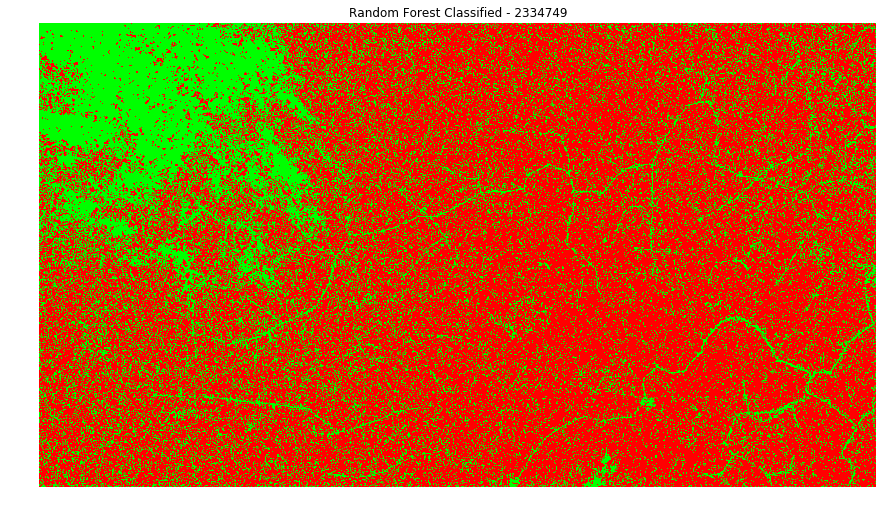

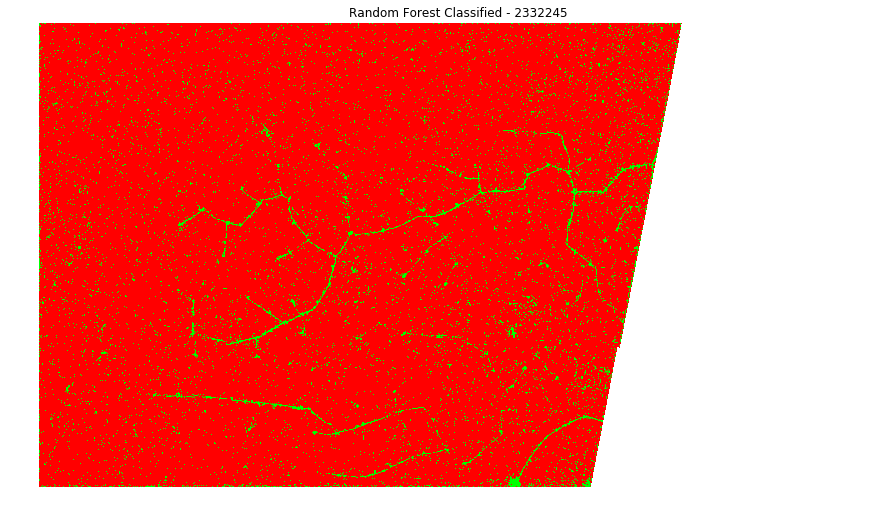

In [64]:
# separate the class numbers into rgb bands
def classified_band_to_rgb(classified_band):
    return [classified_band == n for n in [0,1,2]]

for strip_id in strip_searcher.get_strip_ids(good_scenes):
    img_filename = strip_downloader.get_filename(strip_id, asset_type)
    with Timer():
        y_band_rf = classify_forest(img_filename, X_training, y_training)
    title = 'Random Forest Classified - {}'.format(strip_id)
    visual.plot_image(classified_band_to_rgb(y_band_rf), title=title, figsize=(15, 15))

Unfortunately, the imagery available with UDM2 isn't as good as the imagery used earlier. While the results from one of the strips are pretty good, the other strip appears to be conaminated by haze which wasn't filtered out by the UDM2 mask.